In [15]:
import numpy as np
import random
import os
import sys
import time
import pandas as pd
import openmatrix as omx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

In [2]:
data_name = 'TransportationNetworks-master/Anaheim/Anaheim'
MAX_COST = 1e4 # max drive time in minute

Turning road segments into link objects

In [3]:
# road segment object
class RLink:
    """
    BPR is used for cost function as t_a(q_a)=t_a(0)*(b*(q_a/capacity_a)^power)
    """
    def __init__(self, index, in_node, out_node, free_flow_time, capacity, \
                 distance, toll, toll_factor=0, dist_factor=0, b=2.26, power=5.0):
        self.index, self.in_node, self.out_node = int(index), int(in_node), int(out_node)
        self.free_flow_time = free_flow_time
        self.travel_time = free_flow_time
        self.capacity = capacity
        
        self.distance = distance
        self.toll = toll
        self.dist_factor = dist_factor
        self.toll_factor = toll_factor
        self.b, self.power = b, power
        
        self.generalized_cost = self.compute_gcost()
        
    def BPR(self, flow):
        return self.free_flow_time*(1+self.b*np.power(flow/self.capacity, self.power))    
    
    def compute_gcost(self):
        return self.travel_time + self.toll_factor * self.toll \
                                + self.dist_factor * self.distance
    
    def update_time(self, time):
        self.travel_time = time
        self.generalized_cost = self.compute_gcost()

In [4]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces

def load_network(filename):
    net = pd.read_csv(filename+'_net.tntp', skiprows=8, sep='\t')

    trimmed= [s.strip().lower() for s in net.columns]
    net.columns = trimmed

    # And drop the silly first andlast columns
    net.drop(['~', ';'], axis=1, inplace=True)
    net.init_node = net.init_node - 1
    net.term_node = net.term_node - 1
    return net
    
roads = load_network(data_name)
roads.head()

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,0,116,9000,5280,1.090458,0.15,4,4842,0,1
1,1,86,9000,5280,1.090458,0.15,4,4842,0,1
2,2,73,9000,5280,1.090458,0.15,4,4842,0,1
3,3,232,9000,5280,1.090458,0.15,4,4842,0,1
4,4,164,9000,5280,1.090458,0.15,4,4842,0,1


In [5]:
n_node = roads['init_node'].append(roads['term_node']).unique().shape[0]
n_node

416

In [6]:
links = []
for _,row in roads.iterrows():
    links.append(RLink(_, row['init_node'], row['term_node'], \
                       row['free_flow_time'], row['capacity'], \
                      row['length'], row['toll']))

Turning OD pairs into objects. Searching for all paths for each OD pair

In [7]:
# origin-destination (OD) pairs
class ODPair:
    """
    demand: flow
    paths: list of paths from origin to dest
    p_paths: possibility each path is chosen
    """
    def __init__(self, index, origin, dest, demand, theta=1.0):
        self.index, self.origin, self.dest = index, origin, dest
        self.demand = demand

In [8]:
# Function to load OD pairs
def load_ODpairs(matfile):
    f = open(matfile+'_trips.tntp', 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        orig=int(orig[0])

        d = [eval('{'+a.replace(';',',').replace(' ','') +'}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[orig] = destinations
        
    zones = max(matrix.keys())
    ODpairs = []
    for i in range(zones):
        for j in range(zones):
            ODpairs.append(ODPair(i*zones+j, i, j, matrix.get(i+1,{}).get(j+1,0)))

    return ODpairs   

ODpairs = load_ODpairs(data_name)

Build the network and compute optimized traffic flow

In [9]:
class Network:
    def __init__(self, n_node, links, odpairs, beta=0.051, tol=1e-6):
        self.n_node = n_node
        self.links = links
        self.beta = beta # cognitive bias factor of users
        self.tol = tol
        
        # map origins to shortest path indices
        self.odpairs = sorted(odpairs, key=lambda x: (x.origin, x.dest))
        self.origins = {}
        id_p = 0
        for i in range(len(self.odpairs)):
            if self.odpairs[i].origin not in self.origins:
                self.origins[self.odpairs[i].origin] = id_p
                id_p += 1
        
        self.link_flow = np.zeros((n_node, n_node))
#         self.shortest_path_cost, self.shortest_path_pre = self.update_shortest_path()
        
#         self.link_flow = self.update_link_flow()
        
#         self.update_travel_time()
        
    def update_shortest_path(self):
        # init links provided
        graph = np.full((n_node, n_node), MAX_COST)
        np.fill_diagonal(graph, 0)
        for link in self.links:
            graph[link.in_node][link.out_node] = link.travel_time
            
        graph = csr_matrix(graph)
        return shortest_path(csgraph=graph, indices=list(self.origins.keys()), return_predecessors=True)
    
    def update_link_flow(self, n, hist_flow):
        link_flow = np.zeros((n_node, n_node))
        for i, odp in enumerate(self.odpairs):
            cur = odp.dest
            pre = self.shortest_path_pre[self.origins[odp.origin]][cur]
            while pre != -9999:
                link_flow[pre][cur] += odp.demand
                cur = pre
                pre = self.shortest_path_pre[self.origins[odp.origin]][cur]
                
        return link_flow, 1/n*((n-1)*hist_flow+link_flow)
    
    def update_travel_time(self):
        for link in self.links:
            link.travel_time = link.BPR(self.link_flow[link.in_node][link.out_node])
        

In [25]:
def MC_SUE(network):
    
    hist_sigma, sigma = 0, 0
    hist_t, t = 0, 0 # execution time
    uncertainty, FOM = [], []
    dst = [] # record dst of sigma
    
    start_time = time.time()
    for n in range(1, 10001): # max number of sampling process
        
        hist_flow = network.link_flow.copy()
        n_node, links, odpairs = network.n_node, network.links, network.odpairs
        beta = network.beta
        for i, link in enumerate(links):
            link.travel_time = np.random.normal(link.travel_time, beta*link.travel_time)

        network.shortest_path_cost, network.shortest_path_pre = network.update_shortest_path()
        cur_link_flow, network.link_flow = network.update_link_flow(n, hist_flow)
        network.update_travel_time()
        
        if n == 2:
            hist_sigma = np.abs(cur_link_flow-network.link_flow)
            hist_t = time.time() - start_time
            
        elif n > 2:
            sigma = np.sqrt(1/(n-1)/(n-1)*(cur_link_flow-network.link_flow)**2\
                                +(n-2)/n*hist_sigma*hist_sigma)
            
            dst.append(np.max(sigma))
            
            # compute uncertainty
            R1 = np.nanmax(hist_sigma/hist_flow)
            R2 = np.nanmax(sigma/network.link_flow)
            uncertainty.append(np.abs(R2/R1-np.sqrt((n-1)/n)))
            
            # compute FOM
            t = time.time() - start_time
            FOM.append(np.abs(1/(R2*R2*t)-1/(R1*R1*hist_t)))
            
            if np.max(sigma) < network.tol:
                return network
            
            hist_sigma = sigma
            hist_t = t
            
            print(n, np.max(sigma))
    
    print('Total execution time:', t)
    return uncertainty, FOM, dst, network
                   
 
network = Network(n_node, links, ODpairs)
# network.link_flow[network.link_flow != 0]
uncertainty, FOM, sigmas, res_net = MC_SUE(network)
with open('results3.npy', 'wb') as f:
    np.save(f, np.array(uncertainty))
    np.save(f, np.array(FOM))
    np.save(f, np.array(sigmas))

<ipython-input-25-3b6580efdfd0>:32: RuntimeWarning: invalid value encountered in true_divide
  R1 = np.nanmax(hist_sigma/hist_flow)
<ipython-input-25-3b6580efdfd0>:33: RuntimeWarning: invalid value encountered in true_divide
  R2 = np.nanmax(sigma/network.link_flow)


3 5008.510788980426
4 3588.674446667831
5 2782.6480299527634
6 2303.103031527971
7 2093.494552600676
8 1893.2428005371396
9 1671.8281957888394
10 1503.7937952207556
11 1385.9139358274238
12 1309.6541373082766
13 1210.6046473760623
14 1166.1836805250362
15 1114.372307718351
16 1042.802606241149
17 981.4007215058205
18 934.6139249104564
19 889.4259734150377
20 844.2746718929803
21 804.0004605683407
22 766.7546580051593
23 740.1238698131041
24 716.2215534093382
25 694.9191718399101
26 679.5999840408208
27 653.9566940843106
28 638.4680175727996
29 619.8384974833843
30 604.4166694973624
31 585.2518933692864
32 566.6677660291361
33 556.698413381355
34 540.3077521977983
35 527.3885224527418
36 518.6181320383702
37 512.9323259902574
38 499.53289841883065
39 486.9436460461525
40 478.9297326061504
41 471.67365920730185
42 462.3411716854249
43 451.8118967063709
44 444.87019134065946
45 438.47280078990957
46 429.355895631132
47 420.12210024737277
48 412.60996899685796
49 404.71919378295684
50 397.

371 102.76026328845681
372 102.63043642051747
373 102.36565553647928
374 102.09910024167819
375 101.86910623140712
376 101.61119020157865
377 101.36756533385636
378 101.1348907747512
379 100.96159979527663
380 100.82527584795035
381 100.59827152043212
382 100.44305067745152
383 100.52344372750099
384 100.26250906007554
385 100.0210328196969
386 99.8866663739722
387 99.63636068125165
388 99.38912709865107
389 99.26114607850928
390 100.06688932557047
391 100.0286532310967
392 99.79218822995784
393 99.7535582497259
394 99.97704868331395
395 99.72362714800842
396 99.48555448973949
397 99.25047138008789
398 99.0010578648486
399 98.8748858363105
400 98.64427314122906
401 98.4103721944028
402 98.18978236534454
403 97.97145684078194
404 97.85943480142612
405 97.62863725126574
406 97.38803518950891
407 97.22528905761031
408 97.00199317510646
409 97.02641031918587
410 96.80490768386863
411 97.1122341191878
412 96.89188104572571
413 97.12703368071044
414 96.89898194930261
415 96.97338354659549
41

747 70.61259551909735
748 70.51844473015626
749 70.45773035759294
750 70.44658427887761
751 70.35697627451597
752 70.34704307370302
753 70.25773908537896
754 70.17093626544346
755 70.17647312641148
756 70.0874178459583
757 70.04115719991995
758 70.00178592450905
759 69.94891061296778
760 69.9503342937667
761 69.9317335802874
762 69.99743740805924
763 69.94379284191238
764 69.9551480787545
765 69.87813691636688
766 69.83868678971156
767 69.82862415305613
768 69.84661558984367
769 69.76469488301692
770 69.70949096139873
771 69.62621977449461
772 69.58159945547946
773 69.50085273710457
774 69.41393303063256
775 69.32707122153816
776 69.2766781110245
777 69.23812806790367
778 69.15864229168466
779 69.07462915290459
780 68.98839299338395
781 68.90404111167601
782 68.82276082709491
783 68.74758166616002
784 68.65988827334122
785 68.6525019135408
786 68.56968617307545
787 68.48488668958424
788 68.39849426801806
789 68.3150213524779
790 68.22853753759863
791 68.20638345020794
792 68.1897757049

1116 55.51875662738034
1117 55.486325872895
1118 55.503072093176364
1119 55.45347397478607
1120 55.41327288304269
1121 55.39347903682477
1122 55.3563300228075
1123 55.37212524207967
1124 55.32318209594452
1125 55.284426181507044
1126 55.24653068406898
1127 55.20271225793937
1128 55.20098631374887
1129 55.15838260786152
1130 55.11164953493284
1131 55.068046918024876
1132 55.0194299877691
1133 54.97837224193439
1134 54.93156391303122
1135 54.88656052668093
1136 54.84694196044929
1137 54.79903496742971
1138 54.75233595979091
1139 54.743559616163495
1140 54.695541432092725
1141 54.72309837932154
1142 54.677731213925995
1143 54.70885371905546
1144 54.70747773758033
1145 54.72924401570885
1146 54.68146644638763
1147 54.646451091710375
1148 54.61091201149089
1149 54.56403703844894
1150 54.53231743655107
1151 54.4885062729485
1152 54.44161280618088
1153 54.424823475562164
1154 54.37850710787906
1155 54.33173406978923
1156 54.29006375306343
1157 54.250492309315504
1158 54.21326997949774
1159 54

1470 47.20856088751045
1471 47.189620703249105
1472 47.18079813294934
1473 47.20743189894808
1474 47.192970976053914
1475 47.19351855457587
1476 47.19054800472287
1477 47.17927159860994
1478 47.215951839584406
1479 47.19199512920154
1480 47.17838624013161
1481 47.18056294343922
1482 47.161964230705465
1483 47.130404769802354
1484 47.10651948950148
1485 47.08615228631346
1486 47.10151963008222
1487 47.0719472619463
1488 47.080743984402346
1489 47.05256057693699
1490 47.06964556323736
1491 47.04589997543607
1492 47.04621888346471
1493 47.01977657689456
1494 46.99397875311154
1495 46.96256380415599
1496 46.9513509721013
1497 46.920062954044106
1498 46.89423352018131
1499 46.90047652284292
1500 46.90895625226471
1501 46.8930201330357
1502 46.883162816051
1503 46.87242639356439
1504 46.87264213060999
1505 46.84390642869577
1506 46.82549923212214
1507 46.81210136774428
1508 46.81228334324803
1509 46.81535348473914
1510 46.85030100266065
1511 46.84205264069204
1512 46.81157333332414
1513 46.7

1824 42.658817025303854
1825 42.63937161595307
1826 42.62615087062397
1827 42.60683675176898
1828 42.601015670698104
1829 42.597479592461646
1830 42.574215566678944
1831 42.556762551766475
1832 42.536682231234316
1833 42.51350018596261
1834 42.491574398452585
1835 42.49108273185524
1836 42.49085080768911
1837 42.56966060946169
1838 42.54668011487723
1839 42.52523326629902
1840 42.52146897040304
1841 42.50940998446783
1842 42.48635686820493
1843 42.46355728161181
1844 42.444191140018745
1845 42.43900401307677
1846 42.41800061121216
1847 42.39875361259708
1848 42.396234269040406
1849 42.37369536829547
1850 42.352365901030495
1851 42.36600657988291
1852 42.34476666755873
1853 42.33669250673341
1854 42.314902595647546
1855 42.318460475936746
1856 42.344695249679546
1857 42.33705345756878
1858 42.342883614148164
1859 42.34308867776944
1860 42.321188792633066
1861 42.32523319897421
1862 42.30378230340491
1863 42.28193957628129
1864 42.284381751382405
1865 42.28877661845928
1866 42.2787673179

2178 38.88716200483976
2179 38.87130585234971
2180 38.8547991602794
2181 38.8389651108821
2182 38.833908664013684
2183 38.84060632754421
2184 38.82760241986536
2185 38.827683211921155
2186 38.8141706351029
2187 38.81438650478805
2188 38.80539121991317
2189 38.78789650940084
2190 38.7711512169499
2191 38.77134756668836
2192 38.782406187673296
2193 38.76530376882075
2194 38.74978195462791
2195 38.73216638438877
2196 38.71948310148318
2197 38.706086804258746
2198 38.691111717895154
2199 38.694655051434225
2200 38.67837638660337
2201 38.6608110242123
2202 38.6442745266645
2203 38.62779178259524
2204 38.6122396869477
2205 38.60822482654151
2206 38.601772699068086
2207 38.598473525643165
2208 38.59679994233657
2209 38.589336882416625
2210 38.57215024772489
2211 38.555314547697414
2212 38.538252429327855
2213 38.521024559756604
2214 38.51619372048963
2215 38.49881150835342
2216 38.4990428649638
2217 38.48505171616963
2218 38.477489506608954
2219 38.462090451601405
2220 38.44666199270387
2221 

2533 36.03014284536245
2534 36.02176496598074
2535 36.009849406278555
2536 35.996670540253
2537 35.9945811262454
2538 35.98825902922846
2539 35.97770557806809
2540 35.96742076155273
2541 35.955267392754905
2542 35.943367550628835
2543 35.930896673384815
2544 35.9184486250894
2545 35.91120363771052
2546 35.91123782816416
2547 35.89715354775763
2548 35.88530849853125
2549 35.87347825723197
2550 35.86112624840647
2551 35.84729396378651
2552 35.835997240837735
2553 35.82879575417067
2554 35.81756437144172
2555 35.80482104391904
2556 35.79136466516213
2557 35.785312846396344
2558 35.79310473092248
2559 35.78705443895494
2560 35.787107909443115
2561 35.778287816427586
2562 35.76437649557006
2563 35.76987677621455
2564 35.769903858283165
2565 35.757001873440664
2566 35.749825994183944
2567 35.740808396602795
2568 35.726899892510254
2569 35.71398283998418
2570 35.701296935410525
2571 35.68741552619303
2572 35.706342414869376
2573 35.69327087386905
2574 35.68106236027655
2575 35.667551859962295

2887 33.60223535704631
2888 33.61053696827118
2889 33.59943988985956
2890 33.59131007660558
2891 33.580264506106786
2892 33.56931945708932
2893 33.55842492181139
2894 33.54928099661685
2895 33.54625120822861
2896 33.54639875913501
2897 33.54653401399936
2898 33.539372293283506
2899 33.52843285132643
2900 33.52200000965726
2901 33.55149273769417
2902 33.54286770278945
2903 33.54121129991035
2904 33.52973462055874
2905 33.52468851952665
2906 33.515326193197
2907 33.51421406223131
2908 33.50485619545022
2909 33.49638958057517
2910 33.48488210802003
2911 33.474763561977134
2912 33.46331970925872
2913 33.46382427746412
2914 33.45473524259586
2915 33.45939139528618
2916 33.46190819013841
2917 33.467690065429096
2918 33.46265726533336
2919 33.453120335570375
2920 33.449408948553184
2921 33.44829065527216
2922 33.43759677787581
2923 33.430224607892065
2924 33.42716528200484
2925 33.418549889437784
2926 33.40799826811349
2927 33.396750245566636
2928 33.3885284546159
2929 33.38743665990589
2930 

3240 31.78750004403631
3241 31.779488136083728
3242 31.779592928205886
3243 31.769864558485946
3244 31.76182086228544
3245 31.752488471826034
3246 31.744453335379035
3247 31.7394587248838
3248 31.735237299616532
3249 31.72582281107728
3250 31.717639136130003
3251 31.708094271090438
3252 31.703142789479582
3253 31.694357748376145
3254 31.686449150058674
3255 31.677432146337434
3256 31.66777491916088
3257 31.65913081548725
3258 31.66201369995065
3259 31.652304686623452
3260 31.6426514161243
3261 31.635375597225387
3262 31.625680685275817
3263 31.62154106074753
3264 31.620388405708766
3265 31.611260121939264
3266 31.604054044991145
3267 31.597697568415427
3268 31.597826142639995
3269 31.588163388348224
3270 31.588845976551692
3271 31.580860771910498
3272 31.58234969609509
3273 31.572786382338965
3274 31.56753030236854
3275 31.55950412106995
3276 31.5502969071451
3277 31.54103873243358
3278 31.545409091309622
3279 31.537807158552592
3280 31.528201548938842
3281 31.518753991738272
3282 31.5

3588 30.078409478484527
3589 30.07910732705051
3590 30.076282325858713
3591 30.070770029059915
3592 30.06339507286059
3593 30.055084430801887
3594 30.046727096715628
3595 30.04315848632951
3596 30.03480920265143
3597 30.042924050247915
3598 30.03843907566871
3599 30.03016872398363
3600 30.021882847114487
3601 30.013598974068643
3602 30.0202969374383
3603 30.01475862547093
3604 30.02677890366208
3605 30.021871409937916
3606 30.01373441502372
3607 30.00801340619833
3608 30.004837462286115
3609 30.005153163341095
3610 29.998331038734957
3611 29.990262787530572
3612 29.98344732170825
3613 29.98483982335368
3614 29.97655138714358
3615 29.969249868079853
3616 29.965423610594712
3617 29.958020943880843
3618 29.95982313759611
3619 29.952587000293054
3620 29.95800911241311
3621 29.95005384712152
3622 29.942701873659008
3623 29.94272664584373
3624 29.96147095213615
3625 29.954686262466737
3626 29.951164273821682
3627 29.9431385632323
3628 29.943257027709063
3629 29.94083988232561
3630 29.9341463

3936 28.73038195919998
3937 28.73051014693143
3938 28.72688481165881
3939 28.738794927197514
3940 28.742813046848294
3941 28.73989793319136
3942 28.73341931415352
3943 28.733536404062566
3944 28.756256865907133
3945 28.752454055568982
3946 28.753257653392442
3947 28.750322786479387
3948 28.74309094807416
3949 28.739887920285113
3950 28.74193196743123
3951 28.739746144194264
3952 28.736535368620686
3953 28.729311488547363
3954 28.723400603698938
3955 28.73179181722142
3956 28.725064677221027
3957 28.718610896757
3958 28.711359495716486
3959 28.712082247318403
3960 28.70534180294743
3961 28.69814083863355
3962 28.692256152128422
3963 28.68601859252258
3964 28.678783840620746
3965 28.672409295273308
3966 28.66941320406963
3967 28.66567973083944
3968 28.659226441775072
3969 28.65253798142908
3970 28.650587888079233
3971 28.64390375284911
3972 28.65223342246567
3973 28.64914785706926
3974 28.642986132604335
3975 28.63671804075677
3976 28.634898788524445
3977 28.627828477634427
3978 28.62064

4285 27.530529616926565
4286 27.544279036450938
4287 27.544380740912132
4288 27.538915614522335
4289 27.541544514857492
4290 27.5352262802221
4291 27.538742027375534
4292 27.533325441521416
4293 27.527077849327004
4294 27.520985484453902
4295 27.52107231546216
4296 27.51498328857993
4297 27.515066179919472
4298 27.51183933543119
4299 27.513615516542146
4300 27.513690178629112
4301 27.507757979608446
4302 27.502191983137614
4303 27.510925877394616
4304 27.505020790531116
4305 27.498757144405435
4306 27.493437787976973
4307 27.505570488753783
4308 27.499959438053967
4309 27.49383598350437
4310 27.48866976977431
4311 27.48594069876685
4312 27.483218402713373
4313 27.485802498031898
4314 27.479691659525283
4315 27.477594909450417
4316 27.47319013793868
4317 27.47424414237469
4318 27.468658267778203
4319 27.46308929723141
4320 27.457501569762268
4321 27.455336386662307
4322 27.449538691194665
4323 27.450582519293558
4324 27.465178503508675
4325 27.459426341985385
4326 27.456715377218565
432

4633 26.47933198958813
4634 26.47369839892402
4635 26.48558551385437
4636 26.4798813848881
4637 26.474288532967886
4638 26.469140753681785
4639 26.4639359042391
4640 26.4594213728628
4641 26.453753104379206
4642 26.448071729762788
4643 26.44270299347437
4644 26.43729207895065
4645 26.43180732690154
4646 26.42938382063752
4647 26.424818027584248
4648 26.419760606636146
4649 26.417002390445145
4650 26.41709103649897
4651 26.411754281586017
4652 26.411765297855418
4653 26.407815949707327
4654 26.402148135522612
4655 26.397544137846847
4656 26.39512502436398
4657 26.394958652277726
4658 26.395042187018184
4659 26.39240098781824
4660 26.394095108568013
4661 26.40227960806852
4662 26.398368123762435
4663 26.39352971301289
4664 26.393609156222876
4665 26.388364095320966
4666 26.383037096440745
4667 26.37742050008303
4668 26.377496901668373
4669 26.37330804260043
4670 26.369455794882704
4671 26.369534739582015
4672 26.371738777985332
4673 26.37120268119163
4674 26.368810874791617
4675 26.37043

4980 25.46684256824839
4981 25.462285098981635
4982 25.46013414448425
4983 25.460230914077957
4984 25.456086157170308
4985 25.452321296372574
4986 25.450612763246646
4987 25.44932341418862
4988 25.444225403484978
4989 25.443070509984153
4990 25.449026648789516
4991 25.444164587752894
4992 25.44685715139069
4993 25.441795854680713
4994 25.442230602606678
4995 25.44006490108049
4996 25.44284837517077
4997 25.437804012073048
4998 25.43789418587451
4999 25.44008833840295
5000 25.440923193719517
5001 25.4358418352251
5002 25.435649572512094
5003 25.433233139151046
5004 25.42820420392152
5005 25.43103461452503
5006 25.426048437861276
5007 25.426408103132953
5008 25.421540440212613
5009 25.419824593431304
5010 25.416626770948934
5011 25.411625137625943
5012 25.411912285895326
5013 25.40699408974511
5014 25.407092214398556
5015 25.40306851573308
5016 25.4000923320516
5017 25.39512263374512
5018 25.39070463943659
5019 25.390017732072465
5020 25.385947451564693
5021 25.381325969006397
5022 25.37

5329 24.5010230113321
5330 24.497006848508313
5331 24.49271335296562
5332 24.493759040914817
5333 24.4897152406612
5334 24.485226460333095
5335 24.480770053657043
5336 24.476463056714366
5337 24.47375904977738
5338 24.469344603011393
5339 24.46759205241779
5340 24.463371536941192
5341 24.459999817779092
5342 24.45818383752267
5343 24.458343090528242
5344 24.454000406656604
5345 24.452101966197393
5346 24.44840943519287
5347 24.44487261149935
5348 24.440874310430285
5349 24.438010622916398
5350 24.433811476559733
5351 24.429245747327702
5352 24.427741146215745
5353 24.423270975001596
5354 24.42213656070631
5355 24.420248410355153
5356 24.42217052844001
5357 24.418108727316717
5358 24.413700360462805
5359 24.409195863567952
5360 24.413014031797818
5361 24.409881009097386
5362 24.405772415847753
5363 24.4012242043505
5364 24.39695319676764
5365 24.393952714856447
5366 24.399415954490216
5367 24.394952850374725
5368 24.399608377664535
5369 24.395065717064615
5370 24.39270152494253
5371 24.

5676 23.72124901755839
5677 23.717827994585463
5678 23.713808303755627
5679 23.710430842765533
5680 23.70634528821176
5681 23.704259630734764
5682 23.70028287563951
5683 23.701528006854378
5684 23.69759093601433
5685 23.701568221472858
5686 23.699825478932762
5687 23.697742668373415
5688 23.694372523798563
5689 23.692590490950025
5690 23.688720126658176
5691 23.687594850822386
5692 23.683436923886934
5693 23.679918758860154
5694 23.675847501636387
5695 23.672518756145315
5696 23.668365403041985
5697 23.664719678727312
5698 23.660719462911
5699 23.658140758166073
5700 23.657196554408365
5701 23.653511719145857
5702 23.653643545640588
5703 23.649817697455074
5704 23.64571772637949
5705 23.660562101192824
5706 23.65666547467952
5707 23.652522568768816
5708 23.64874251222293
5709 23.644907722666854
5710 23.641607488176636
5711 23.639880638365263
5712 23.63588788937752
5713 23.63454008491156
5714 23.634215171234224
5715 23.630401047368142
5716 23.631331046095283
5717 23.63123195840347
5718 

6023 22.97397178407881
6024 22.97369229850037
6025 22.970518369244957
6026 22.966909793745565
6027 22.963513358417526
6028 22.96365635713162
6029 22.959849998085623
6030 22.956299747372636
6031 22.95472463716105
6032 22.95120392233378
6033 22.948026165164954
6034 22.94710604825488
6035 22.944754187772116
6036 22.941032510132924
6037 22.937312038789415
6038 22.935108801070612
6039 22.931771163444804
6040 22.931916221875177
6041 22.928814116746512
6042 22.92579614764426
6043 22.922206815388897
6044 22.9222995301558
6045 22.91927133907883
6046 22.915835490116446
6047 22.912329301876397
6048 22.908620891281455
6049 22.905355928882273
6050 22.90176178742542
6051 22.90148470438587
6052 22.901626118342197
6053 22.90028196837179
6054 22.896781069215912
6055 22.893227651070248
6056 22.891031173096632
6057 22.888030229903343
6058 22.884489808978135
6059 22.882102871070735
6060 22.878752094039825
6061 22.88140363806649
6062 22.88681759186092
6063 22.889591346809414
6064 22.886086801761092
6065 22

6373 22.338697384793154
6374 22.338509211246027
6375 22.33955192038834
6376 22.33781866525119
6377 22.33431863966121
6378 22.33344670375423
6379 22.331149050486808
6380 22.327654119346793
6381 22.331691194034512
6382 22.328921249553932
6383 22.326066697695516
6384 22.326000487253726
6385 22.32427127389802
6386 22.32117378279519
6387 22.317943638443634
6388 22.31496640495896
6389 22.311738035532926
6390 22.308273331670716
6391 22.3050469602678
6392 22.301679419600855
6393 22.2985949177892
6394 22.296021001236085
6395 22.292737974988786
6396 22.290414750083922
6397 22.288448850118705
6398 22.28538345976124
6399 22.28395126922873
6400 22.280638429142943
6401 22.277904262770264
6402 22.27548112373449
6403 22.272830349341174
6404 22.27125974983109
6405 22.26801973038122
6406 22.264569727084712
6407 22.270879542807933
6408 22.271018675576187
6409 22.267575246011834
6410 22.265284816746778
6411 22.26713354275619
6412 22.266594979158562
6413 22.263553290552405
6414 22.26027015299528
6415 22.25

6721 21.76483797585077
6722 21.764606790064747
6723 21.766038761527515
6724 21.76526948463839
6725 21.76227826575256
6726 21.762727426717145
6727 21.76804851711878
6728 21.764813051964218
6729 21.765761235575148
6730 21.76670709127906
6731 21.763870833514293
6732 21.764220536077342
6733 21.761030703757093
6734 21.762918426597604
6735 21.7615858923555
6736 21.758877721699687
6737 21.75727841784773
6738 21.754386978387036
6739 21.751345971566053
6740 21.749747795779047
6741 21.746539467797966
6742 21.744116927471122
6743 21.74120136269916
6744 21.73938005039707
6745 21.739622526872182
6746 21.736566508867863
6747 21.733947464542464
6748 21.730749944033057
6749 21.728637062409277
6750 21.725912609248365
6751 21.722904256313623
6752 21.720376847583143
6753 21.717968640027475
6754 21.714781219515725
6755 21.71496397419727
6756 21.71415278220565
6757 21.710943683133923
6758 21.70782498303809
6759 21.704613961851766
6760 21.70140652608343
6761 21.69845117377451
6762 21.695864374203204
6763 21

7069 21.271918025258948
7070 21.27041828198335
7071 21.267411368519287
7072 21.26555147045794
7073 21.263057629160595
7074 21.260672828260684
7075 21.259445231226675
7076 21.256442420805264
7077 21.253798549573272
7078 21.25113020488433
7079 21.248214793252792
7080 21.245388656880493
7081 21.246658205210956
7082 21.244265644155547
7083 21.244366906970765
7084 21.243380708528388
7085 21.24055682032472
7086 21.237702074048695
7087 21.238252874017796
7088 21.236762213717558
7089 21.236863096635005
7090 21.23638924436587
7091 21.23354730249787
7092 21.232815751208594
7093 21.229842030763397
7094 21.227346059080013
7095 21.226124487314987
7096 21.223709844303745
7097 21.220944236087735
7098 21.21812840833531
7099 21.21514052441755
7100 21.21317397841725
7101 21.21018980357712
7102 21.20996243022046
7103 21.207094694000226
7104 21.20457521981638
7105 21.204347363507107
7106 21.201762373824632
7107 21.199376288013365
7108 21.196749818894954
7109 21.194547582393167
7110 21.192140468738167
7111

7417 20.785641335211217
7418 20.785727853042314
7419 20.785813167704212
7420 20.784413670527826
7421 20.781835514677628
7422 20.78374223373484
7423 20.78128525236363
7424 20.778995360659145
7425 20.779128854237417
7426 20.778403775738727
7427 20.777266776196917
7428 20.774727221237246
7429 20.77632441892537
7430 20.773532551737556
7431 20.772156234402352
7432 20.76967545193958
7433 20.767663875817092
7434 20.768482075849498
7435 20.766266354079605
7436 20.76347355768609
7437 20.760735165061426
7438 20.759341177518458
7439 20.756569177359903
7440 20.753920947710156
7441 20.751668817908424
7442 20.75144674503556
7443 20.748866614906262
7444 20.746306210846264
7445 20.743524588447148
7446 20.743609466655627
7447 20.741057450406867
7448 20.739687338953754
7449 20.737872631641498
7450 20.738131893911106
7451 20.73534907975718
7452 20.734428743742743
7453 20.73350798784416
7454 20.734131093311422
7455 20.7313686221002
7456 20.729164501363456
7457 20.726387688696267
7458 20.723816573502823
74

7764 20.2714725981311
7765 20.26905620832376
7766 20.266968651608085
7767 20.265881579942477
7768 20.26486214508155
7769 20.26228493904149
7770 20.263844630798527
7771 20.261736195076292
7772 20.261124322821505
7773 20.258862904073496
7774 20.256794333031674
7775 20.25453338802178
7776 20.25238257439761
7777 20.250070288777177
7778 20.247471206310454
7779 20.255577596985678
7780 20.25869108400725
7781 20.2587716684592
7782 20.258205256791758
7783 20.2567599654024
7784 20.255129656177324
7785 20.253845357571763
7786 20.251295268938197
7787 20.251088861464297
7788 20.248534994102357
7789 20.247490257792705
7790 20.24548089576213
7791 20.244182512749067
7792 20.24175399143557
7793 20.239156775581648
7794 20.239674821468316
7795 20.23710267650588
7796 20.234823610874084
7797 20.2329834259754
7798 20.230510755823474
7799 20.228977187567484
7800 20.228773391536514
7801 20.22623499115744
7802 20.223947640500306
7803 20.221383635765207
7804 20.218891141277254
7805 20.219081633843068
7806 20.21

8112 19.811994450583885
8113 19.80974262661518
8114 19.810458174399624
8115 19.81092282344738
8116 19.808708011062322
8117 19.806471875695042
8118 19.804033063538178
8119 19.803737894982685
8120 19.801770036298056
8121 19.80186042507232
8122 19.800159247153978
8123 19.797916670507274
8124 19.796314410622923
8125 19.795305718632672
8126 19.79317325165173
8127 19.793557603689028
8128 19.79156698524761
8129 19.791742857947664
8130 19.79261796026771
8131 19.793260697147595
8132 19.790829382055563
8133 19.788398664192613
8134 19.787392121876007
8135 19.78524956229498
8136 19.78599750816593
8137 19.783739789106242
8138 19.781309677504588
8139 19.78334092060465
8140 19.781460922507726
8141 19.786984448373836
8142 19.786183425015686
8143 19.78599329089161
8144 19.786738608828475
8145 19.78499297508597
8146 19.782566138884377
8147 19.781560227266464
8148 19.779190750192523
8149 19.7770381927251
8150 19.781345879358003
8151 19.78031173511683
8152 19.778067847914794
8153 19.778154600239436
8154 1

8460 19.454865486335105
8461 19.453487619880143
8462 19.453559997847318
8463 19.45135632656544
8464 19.45066091038542
8465 19.45365997192003
8466 19.451976347411925
8467 19.449804843793522
8468 19.44753170499593
8469 19.446601884780456
8470 19.44447797474068
8471 19.44393898162088
8472 19.441924889174523
8473 19.440233630814088
8474 19.438332226805056
8475 19.436090090688648
8476 19.4338209880532
8477 19.431730426199966
8478 19.429462087251917
8479 19.42735059124881
8480 19.42623723566277
8481 19.423959853836166
8482 19.421880675123255
8483 19.419762932855775
8484 19.41747642894241
8485 19.415754766384364
8486 19.413467095269908
8487 19.411509085607705
8488 19.41025981097516
8489 19.408090055072673
8490 19.405953856040313
8491 19.40386911044761
8492 19.4017243618132
8493 19.399442192883214
8494 19.39846476987133
8495 19.3966798177645
8496 19.394484134224275
8497 19.392269386565264
8498 19.39132292251153
8499 19.391401345061613
8500 19.389190564781174
8501 19.389016315086778
8502 19.386

8807 19.029190393539075
8808 19.027122615158536
8809 19.025795447786574
8810 19.024286578551767
8811 19.02221238648114
8812 19.022295863463043
8813 19.02014951399064
8814 19.020203652256953
8815 19.019313541598628
8816 19.018423260864523
8817 19.016349810829396
8818 19.014577676036016
8819 19.014695193860952
8820 19.013491172607104
8821 19.012973095623558
8822 19.01081891496837
8823 19.01022143143671
8824 19.00863709429915
8825 19.006486011298406
8826 19.004339358537685
8827 19.00224644823513
8828 19.00350444673324
8829 19.002538420892417
8830 19.010098387008256
8831 19.008191380231967
8832 19.00620258084376
8833 19.004997223434504
8834 19.003007125364086
8835 19.003051117403366
8836 19.000998003374104
8837 18.998866904270834
8838 18.996844956878356
8839 18.99580771074567
8840 18.99373008377961
8841 18.994722565130527
8842 18.99301105126265
8843 18.99097418473384
8844 18.988951113750062
8845 18.989473317831834
8846 18.989555571926818
8847 18.989675122007622
8848 18.987691620159385
8849

9155 18.693532373092207
9156 18.69251379911905
9157 18.690510597849624
9158 18.688470661525034
9159 18.686557865590395
9160 18.685134400411208
9161 18.683220663809855
9162 18.681371344613847
9163 18.68121685245534
9164 18.679224468063385
9165 18.677187971405925
9166 18.675255478745527
9167 18.679150279132156
9168 18.6772667417636
9169 18.678131066851936
9170 18.67840155955369
9171 18.68089383351217
9172 18.678875272632485
9173 18.67702553671345
9174 18.67504448594779
9175 18.674173973196417
9176 18.67229244822543
9177 18.6705091352602
9178 18.67057895188575
9179 18.6690605501856
9180 18.66708596271647
9181 18.66556810601924
9182 18.663654110139056
9183 18.661780810406384
9184 18.66299959193081
9185 18.66140121325923
9186 18.660268877977515
9187 18.660731569111377
9188 18.65881953900925
9189 18.662096173271205
9190 18.660592955597757
9191 18.65881026554295
9192 18.657161740711167
9193 18.65517024771403
9194 18.653473438985042
9195 18.65354323730087
9196 18.651639799852674
9197 18.649612

9504 18.32971168478592
9505 18.328031917179832
9506 18.326104069383852
9507 18.32417762575552
9508 18.32240222522618
9509 18.32075914089789
9510 18.318834763178963
9511 18.317806705694903
9512 18.318395255447715
9513 18.31668747738587
9514 18.315244836376067
9515 18.31364186776486
9516 18.312041409794848
9517 18.310268753170217
9518 18.309399941997423
9519 18.310055137502356
9520 18.308730613980234
9521 18.307159512501993
9522 18.305244990335158
9523 18.303732712645836
9524 18.30212638812239
9525 18.302539288911653
9526 18.300785501518547
9527 18.29904202791019
9528 18.297291086474353
9529 18.295466147879996
9530 18.29355987811272
9531 18.292745284164106
9532 18.290970423152764
9533 18.293276220813286
9534 18.29150144802541
9535 18.29208708544955
9536 18.292392470372285
9537 18.29078551287333
9538 18.289010756466716
9539 18.28911935436647
9540 18.287345690127044
9541 18.286915576098032
9542 18.285310011955513
9543 18.285164423235294
9544 18.28772183832413
9545 18.28690508064456
9546 18

9853 17.981180049744065
9854 17.979831338110007
9855 17.978196065381887
9856 17.97648473040297
9857 17.97466160074208
9858 17.97409657991668
9859 17.974902813095508
9860 17.973367018951603
9861 17.97154581178891
9862 17.971121825730457
9863 17.971192899861038
9864 17.970851964482648
9865 17.969324318586473
9866 17.969095707082854
9867 17.96784331094567
9868 17.96607596938799
9869 17.96824001960761
9870 17.967186109182318
9871 17.965366896215812
9872 17.96384899416796
9873 17.966973666421257
9874 17.966374160098376
9875 17.964831096489362
9876 17.96469995497163
9877 17.96308855393773
9878 17.963259663361573
9879 17.96181811464681
9880 17.961001314584667
9881 17.961803803288813
9882 17.96018535084144
9883 17.95840263152142
9884 17.956586782147077
9885 17.954770602685137
9886 17.954766950543696
9887 17.953424692813282
9888 17.95168663766936
9889 17.950937879653882
9890 17.951499177155767
9891 17.952033592425188
9892 17.951159460876454
9893 17.949566378436906
9894 17.94775351145314
9895 17

Explore the result

In [11]:
def res2dataframe(res):
    froms = [link.in_node+1 for link in res.links]
    tos = [link.out_node+1 for link in res.links]
    times, flows = [], []
    for link in res.links:
        times.append(link.travel_time)
        flows.append(res.link_flow[link.in_node][link.out_node])
    res_df = pd.DataFrame(np.array([froms, tos, flows, times]).T, \
                          columns=['from', 'to', 'volume', 'cost'])
    return res_df

res_df = res2dataframe(network)

In [12]:
res_df = res_df.astype({'from': 'int32', 'to': 'int32'})
res_df.head()

,from,to,volume,cost
0,1,117,7074.90000,1.830245
1,2,87,9662.50000,4.605679
2,3,74,7669.00000,2.197589
3,4,233,12173.80000,12.249730
4,5,165,2587.15941,1.095296


In [13]:
res_df.to_csv('estimated.csv')

In [129]:
for i, link in enumerate(network.links):
    print(link.BPR(res_df.loc[i, 'volume']), paths.loc[i, 'cost'])

1.8302452537981688 1.1529198689124769
4.605678920214949 1.3077728285644104
2.197588740614799 1.1766938339006712
12.249729942963878 1.6380226412299237
1.095292628745165 1.0915747901668154
1.6039250538447114 1.1370960748889003
1.8633418146917875 1.1551455588519783
1.0000966332008019 1.0000479629182888
1.0031861775153457 1.0003502412611545
1.0001463762372111 1.0002148057823903
1.0000000064793668 1.0000000040452055
1.0000000000779743 1.0000000072618334
1.0000133176375907 1.0000098253099972
1.000013649870007 1.0000100209136558
1.000000000034131 1.0000000003306155
1.0000000151412345 1.0000000433444538
1.0000055035783293 1.0000048452995247
1.0000004711252442 1.0000006781310156
1.000056366328589 1.0000311616400124
1.0275279825261938 1.0040267800310838
1.0000498307422738 1.0000383883136466
1.0000990200996984 1.0000548992052627
1.0000014637558383 1.0000012667328744
1.0000159429339628 1.000011346426534
1.0023091143145446 1.00067093427705
1.0016881181206114 1.000424240545127
1.0000049382992242 1.0

0.1579701815302553 0.1493725805097793
1.320075758 1.320075758314871
1.8878542227568023 1.8606050732267725
1.004476812508559 1.0000162073834271
2.591609934453694 2.5084106784537887
1.1219888246242413 1.0179964337923006
0.5825204541006023 0.5799336410545489
0.913666629799481 0.5022401351667478
0.6506685186526842 0.5903608102257031
0.5007782177907469 0.5000081036917136
0.5437893863738871 0.577012106539981
0.5918658609145733 0.500223871560977
2.279982770867729 2.279941328772912
0.1490685044292145 0.1490683304087857
1.0 1.0000000016497448
2.000072062713372 2.0000435691407743
0.33712862656641845 0.282887260708259
2.000066797158991 2.000000003569954
0.14919506411569988 0.1490683412656161
1.0 1.0000024274960009
2.0000312577184363 2.000022334504747
1.4260814002374866 1.420111594715303
1.0000156288592181 1.0000111672523735
2.000027299740014 2.0000200418273115
1.0011452443343931 1.000346675403185
2.000112732657178 2.0000623232800248
0.500000369389449 0.5000001705610833
3.852270859932316 3.5799257

2.0001526676496852 2.0000385587663074
2.0000000002660268 2.0000022855122777
2.0000000020967086 2.0000004568940883
2.0000000002955245 2.000005121981581
2.000000000001416 2.0000060644302815
0.2851351956341399 0.2801263780175887
2.0000000004998135 2.0000004568940883
2.0000045692170443 2.0000024037468016
2.028104150597498 2.0000806307197068
2.079924242 2.079924242
2.000000680933085 2.0000098438449894
0.7202708440056806 0.7200766234399
1.7200762833546122 1.720075758
0.5 0.5
0.7200831920493788 0.720079302157071
0.5149190079042489 0.5000264492342517
0.8110515586552332 0.5007208670597094
0.5000051610464343 0.5000024609612473
0.5149190079042489 0.5000264492342517
0.15728740291794155 0.1490683623429277
1.0 1.0000000232967512
0.50536664265239 0.5000788292450092
2.000005734111954 2.0000115541009493
2.3405448782889584 2.0000000093244417
1.000002867055977 1.0000057770504749
2.0000000001559486 2.0000000145236667
1.7201168360089403 1.720075758
0.27992528473658707 0.2799242419999999
1.0003641364779539 

In [19]:
def validation(y, y_hat):
    d = y - y_hat
    mse_f = np.mean(d**2)
    mae_f = np.mean(abs(d))
    rmse_f = np.sqrt(mse_f)
    r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

    print("Results by manual calculation:")
    print("MAE:",mae_f)
    print("MSE:", mse_f)
    print("RMSE:", rmse_f)
    print("R-Squared:", r2_f)
    
validation(paths.cost, res_df.cost)
validation(paths.volume, res_df.volume)

Results by manual calculation:
MAE: 0.22076120908377472
MSE: 4.548569921311024
RMSE: 2.1327376588110933
R-Squared: -9.666537243060334
Results by manual calculation:
MAE: 900.6126206537444
MSE: 2068583.7427005053
RMSE: 1438.2571893442791
R-Squared: 0.6849358555114029


Text(0.5, 1.0, 'FOM')

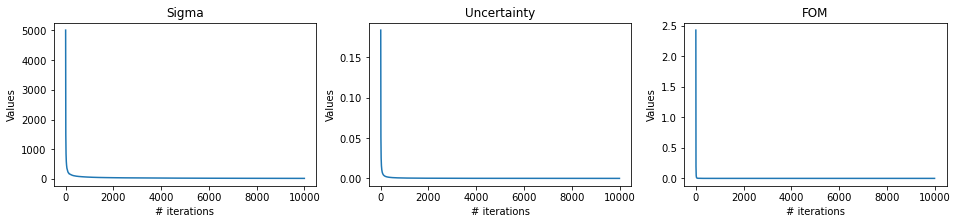

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16,3))
ax[0].plot(sigmas, label='sigma')
ax[0].set_xlabel('# iterations')
ax[0].set_ylabel('Values')
ax[0].set_title('Sigma')
ax[1].plot(uncertainty, label='uncertainty')
ax[1].set_xlabel('# iterations')
ax[1].set_ylabel('Values')
ax[1].set_title('Uncertainty')
ax[2].plot(FOM, label='FOM')
ax[2].set_xlabel('# iterations')
ax[2].set_ylabel('Values')
ax[2].set_title('FOM')

In [25]:
FOM

[8.42488657366398,
 15.388335109504881,
 24.044273608601383,
 34.623753996385986,
 48.423142939663606,
 64.10816304839271,
 82.07070918853127,
 101.90736893867933,
 123.88060867021014,
 135.92940029417332,
 155.75437444485883,
 180.71611296173265,
 207.53143729360724,
 237.1357710737047,
 268.13969384750754,
 300.3293226426867,
 335.61567008932377,
 364.73335607251454,
 400.53999866859533,
 440.5420742412883,
 467.96228366190684,
 507.596357604908,
 526.718377988139,
 558.0386648245119,
 590.631723550358,
 636.0334995260347,
 681.9644602806092,
 702.2611327593479,
 748.5993318164274,
 775.2982288900762,
 795.8858400036734,
 840.7466785363463,
 838.0505055734747,
 851.8254352316701,
 896.1446927283812,
 926.6130857899573,
 948.5943208642124,
 992.7195909523053,
 1040.945385443698,
 1084.5001118204696,
 1128.6727148081784,
 1151.2329048489437,
 1177.7966138477645,
 1230.0702031791946,
 1284.5945812260723,
 1326.2097376443048,
 1366.4657141423204,
 1406.306620758941,
 1461.362020605874,
 

In [40]:
# path cross several road segments
class Path:
    def __init__(self, index, links):
        self.index, self.links = index, links
        
    def update(self, flow, cost):
        self.flow, self.cost = flow, cost

In [15]:
# best known traffic flow solution (answer data)

def load_path(filename):
    flow = pd.read_csv(filename+'_flow.tntp', sep='\t', header=0)
    trimmed = [s.strip().lower() for s in flow.columns]
    flow.columns = trimmed

    return flow
    
paths = load_path(data_name)
paths.head()

,from,to,volume,cost
0,1,117,7074.9,1.152920
1,2,87,9662.5,1.307773
2,3,74,7669.0,1.176694
3,4,233,12173.8,1.638023
4,5,165,2586.8,1.091575


In [22]:
# road intersections only used to plot map
class rnode:
    def __init__(self, index, pos_x, pos_y, is_origin):
        self.index, self.pos_x, self.pos_y, self.is_origin = index, pos_x, pos_y, is_origin
        self.in_links, self.out_links = [], []